<a href="https://colab.research.google.com/github/Parshav1218/Deep_Learning_Project/blob/main/Airline_Delay_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

df_airlines = pd.read_csv("airlines.csv")
df_flights = pd.read_csv("flights.csv")
df_airports = pd.read_csv("airports.csv")

df_airlines.head(), df_flights.head(), df_airports.head()


Saving flights.csv to flights.csv
Saving airlines.csv to airlines.csv
Saving airports.csv to airports.csv


/tmp/ipython-input-3700788875.py:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv("flights.csv")


(  IATA_CODE                 AIRLINE
 0        UA   United Air Lines Inc.
 1        AA  American Airlines Inc.
 2        US         US Airways Inc.
 3        F9  Frontier Airlines Inc.
 4        B6         JetBlue Airways,
    YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
 0  2015      1    1            4      AS             98      N407AS   
 1  2015      1    1            4      AA           2336      N3KUAA   
 2  2015      1    1            4      US            840      N171US   
 3  2015      1    1            4      AA            258      N3HYAA   
 4  2015      1    1            4      AS            135      N527AS   
 
   ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
 0            ANC                 SEA                    5  ...         408.0   
 1            LAX                 PBI                   10  ...         741.0   
 2            SFO                 CLT                   20  ...         811.0   
 3            LAX  

In [7]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import time, os, random, pickle

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


In [8]:
# verify the dataframes exist
print('df_flights' in globals(), 'df_airlines' in globals(), 'df_airports' in globals())
# show first rows for sanity
display(df_airlines.head())
display(df_flights.head())
display(df_airports.head())


True True True


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [9]:
import pandas as pd

df_airlines = pd.read_csv("airlines.csv")
df_flights  = pd.read_csv("flights.csv", low_memory=False)
df_airports = pd.read_csv("airports.csv")

print("Shapes:", df_airlines.shape, df_flights.shape, df_airports.shape)


Shapes: (14, 2) (5819079, 31) (322, 7)


In [10]:
# remove duplicate-named columns and merge airline/airport names safely
df_flights = df_flights.loc[:, ~df_flights.columns.duplicated()]

# Prepare small lookup tables
df_airlines_small = df_airlines[['IATA_CODE', 'AIRLINE']].rename(
    columns={'IATA_CODE':'AIRLINE_CODE', 'AIRLINE':'AIRLINE_NAME'}
)
df_airports_small = df_airports[['IATA_CODE', 'AIRPORT']].rename(
    columns={'IATA_CODE':'AIRPORT_CODE', 'AIRPORT':'AIRPORT_NAME'}
)

# Merge airline name
df_flights = df_flights.merge(df_airlines_small, left_on='AIRLINE', right_on='AIRLINE_CODE', how='left').drop(columns=['AIRLINE_CODE'])

# Merge origin airport name
if 'ORIGIN_AIRPORT' in df_flights.columns:
    df_flights = df_flights.merge(df_airports_small, left_on='ORIGIN_AIRPORT', right_on='AIRPORT_CODE', how='left') \
                           .rename(columns={'AIRPORT_NAME':'ORIGIN_AIRPORT_NAME'}).drop(columns=['AIRPORT_CODE'])
# Merge destination airport name
if 'DESTINATION_AIRPORT' in df_flights.columns:
    df_flights = df_flights.merge(df_airports_small, left_on='DESTINATION_AIRPORT', right_on='AIRPORT_CODE', how='left') \
                           .rename(columns={'AIRPORT_NAME':'DESTINATION_AIRPORT_NAME'}).drop(columns=['AIRPORT_CODE'])

print("After merges, flights shape:", df_flights.shape)


After merges, flights shape: (5819079, 34)


In [11]:
# create label
arr_cols = [c for c in df_flights.columns if 'ARR' in c.upper() and 'DELAY' in c.upper()]
print("Candidate arrival-delay columns:", arr_cols)
if len(arr_cols) == 0:
    raise ValueError("No arrival delay column found. Show df_flights.columns and paste here.")
arr_col = arr_cols[0]
print("Using:", arr_col)

df_flights = df_flights[df_flights[arr_col].notna()].copy()
df_flights['DELAYED'] = (df_flights[arr_col] > 15).astype(int)
print(df_flights['DELAYED'].value_counts())


Candidate arrival-delay columns: ['ARRIVAL_DELAY']
Using: ARRIVAL_DELAY
DELAYED
0    4690510
1    1023498
Name: count, dtype: int64


In [12]:
# choose features and preprocess
cat_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
num_cols = ["YEAR","MONTH","DAY","DAY_OF_WEEK",
            "SCHEDULED_DEPARTURE","SCHEDULED_ARRIVAL","DISTANCE"]

# keep only columns that exist
cat_cols = [c for c in cat_cols if c in df_flights.columns]
num_cols = [c for c in num_cols if c in df_flights.columns]

print("Using categorical:", cat_cols)
print("Using numeric:", num_cols)

df_model = df_flights[cat_cols + num_cols + ["DELAYED"]].dropna().copy()
print("Rows available for modeling:", len(df_model))

# Encode categoricals
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df_model[c] = le.fit_transform(df_model[c].astype(str))
    encoders[c] = le

# Scale numeric
scaler = StandardScaler()
if len(num_cols) > 0:
    df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

X = df_model[cat_cols + num_cols].values.astype(np.float32)
y = df_model["DELAYED"].values.astype(np.int64)

# Stratified split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

print("Train/Val/Test sizes:", len(y_train), len(y_val), len(y_test))

# save encoders/scaler for later inference
with open("encoders_scaler.pkl", "wb") as f:
    pickle.dump({"encoders": encoders, "scaler": scaler, "cat_cols": cat_cols, "num_cols": num_cols}, f)
print("Saved encoders_scaler.pkl")


Using categorical: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
Using numeric: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DISTANCE']
Rows available for modeling: 5714008
Train/Val/Test sizes: 3999805 857101 857102
Saved encoders_scaler.pkl


In [13]:
# PyTorch dataset and loaders
class FlightDataset(Dataset):
    def __init__(self, X, y, n_cat):
        self.X = X
        self.y = y
        self.n_cat = n_cat
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        row = self.X[idx]
        cat = torch.tensor(row[:self.n_cat]).long()
        num = torch.tensor(row[self.n_cat:]).float() if row.shape[0] > self.n_cat else torch.empty(0)
        return cat, num, torch.tensor(self.y[idx]).long()

n_cat = len(cat_cols)
train_ds = FlightDataset(X_train, y_train, n_cat)
val_ds   = FlightDataset(X_val, y_val, n_cat)
test_ds  = FlightDataset(X_test, y_test, n_cat)

BATCH_SIZE = 512
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders ready.")


DataLoaders ready.


In [14]:
# model definition
class LSTMTabularClassifier(nn.Module):
    def __init__(self, cat_cardinalities, cat_embed_dims, n_num, lstm_hidden=128, lstm_layers=1, dropout=0.2):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(card, dim) for card, dim in zip(cat_cardinalities, cat_embed_dims)])
        self.num_proj = nn.Linear(n_num, 32) if n_num > 0 else None
        total_emb = sum(cat_embed_dims)
        input_dim = total_emb + (32 if n_num > 0 else 0)
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True, num_layers=lstm_layers)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, cat_x, num_x):
        emb_list = [emb(cat_x[:, i]) for i, emb in enumerate(self.embs)]
        emb = torch.cat(emb_list, dim=1) if len(emb_list) else torch.empty((cat_x.size(0),0), device=cat_x.device)
        if self.num_proj is not None:
            num_p = torch.relu(self.num_proj(num_x))
            x = torch.cat([emb, num_p], dim=1)
        else:
            x = emb
        x = x.unsqueeze(1)   # seq len = 1
        out, (hn, cn) = self.lstm(x)
        h = out[:, -1, :]
        return self.head(h)

cat_cardinalities = [int(df_model[c].nunique()) for c in cat_cols]
cat_embed_dims = [min(50, (c+1)//2) for c in cat_cardinalities]
model = LSTMTabularClassifier(cat_cardinalities, cat_embed_dims, n_num=len(num_cols)).to(DEVICE)
print(model)


LSTMTabularClassifier(
  (embs): ModuleList(
    (0): Embedding(14, 7)
    (1): Embedding(628, 50)
    (2): Embedding(629, 50)
  )
  (num_proj): Linear(in_features=7, out_features=32, bias=True)
  (lstm): LSTM(139, 128, batch_first=True)
  (head): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [15]:
# training loop
EPOCHS = 12
LR = 1e-3
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
best_val_acc = 0.0
train_losses, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for cat, num, yb in train_loader:
        cat, num, yb = cat.to(DEVICE), num.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(cat, num)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    # validation
    model.eval()
    val_preds, val_trues, val_probs = [], [], []
    with torch.no_grad():
        for cat, num, yb in val_loader:
            cat, num, yb = cat.to(DEVICE), num.to(DEVICE), yb.to(DEVICE)
            logits = model(cat, num)
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds = logits.argmax(1).cpu().numpy()
            val_preds.extend(preds.tolist()); val_trues.extend(yb.cpu().numpy().tolist()); val_probs.extend(probs.tolist())
    val_acc = accuracy_score(val_trues, val_preds)
    val_f1 = f1_score(val_trues, val_preds)
    try:
        val_auc = roc_auc_score(val_trues, val_probs)
    except:
        val_auc = None

    train_losses.append(train_loss); val_accs.append(val_acc)
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_acc={val_acc:.4f} val_f1={val_f1:.4f} val_auc={val_auc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_lstm_airline.pt")
        print("Saved best model (val_acc improved).")

print("Training finished. Best val acc:", best_val_acc)


Epoch 1/12 | train_loss=0.4441 train_acc=0.8210 | val_acc=0.8223 val_f1=0.0606 val_auc=0.6866863995583401
Saved best model (val_acc improved).
Epoch 2/12 | train_loss=0.4345 train_acc=0.8226 | val_acc=0.8238 val_f1=0.0815 val_auc=0.700558619548712
Saved best model (val_acc improved).
Epoch 3/12 | train_loss=0.4287 train_acc=0.8241 | val_acc=0.8252 val_f1=0.1240 val_auc=0.712612310632112
Saved best model (val_acc improved).
Epoch 4/12 | train_loss=0.4238 train_acc=0.8255 | val_acc=0.8272 val_f1=0.1617 val_auc=0.7226217644373079
Saved best model (val_acc improved).
Epoch 5/12 | train_loss=0.4194 train_acc=0.8271 | val_acc=0.8284 val_f1=0.1629 val_auc=0.7298325801141871
Saved best model (val_acc improved).
Epoch 6/12 | train_loss=0.4158 train_acc=0.8285 | val_acc=0.8302 val_f1=0.1897 val_auc=0.7349201149725402
Saved best model (val_acc improved).
Epoch 7/12 | train_loss=0.4131 train_acc=0.8298 | val_acc=0.8315 val_f1=0.2113 val_auc=0.7391999573242998
Saved best model (val_acc improved).
E

TEST Acc: 0.834743122755518 F1: 0.26278040909800654 AUC: 0.7499098292860849
Classification report:
               precision    recall  f1-score   support

           0     0.8433    0.9810    0.9069    703577
           1     0.6539    0.1644    0.2628    153525

    accuracy                         0.8347    857102
   macro avg     0.7486    0.5727    0.5849    857102
weighted avg     0.8094    0.8347    0.7916    857102

Confusion matrix:
 [[690216  13361]
 [128281  25244]]


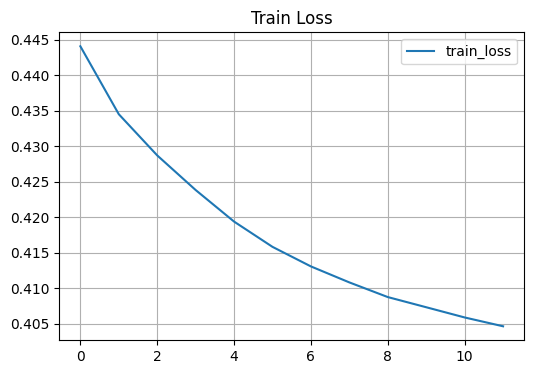

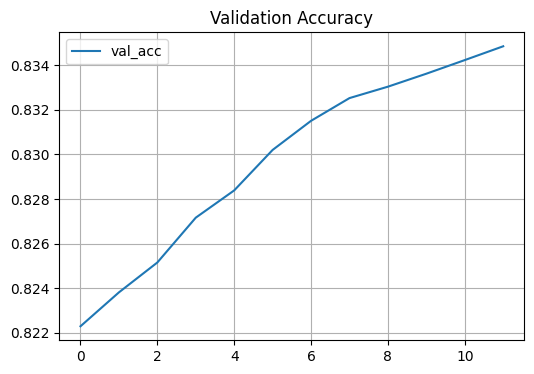

In [16]:
# test eval and plots
model.load_state_dict(torch.load("best_lstm_airline.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

test_preds, test_trues, test_probs = [], [], []
with torch.no_grad():
    for cat, num, yb in test_loader:
        cat, num, yb = cat.to(DEVICE), num.to(DEVICE), yb.to(DEVICE)
        logits = model(cat, num)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()
        test_preds.extend(preds.tolist()); test_trues.extend(yb.cpu().numpy().tolist()); test_probs.extend(probs.tolist())

test_acc = accuracy_score(test_trues, test_preds)
test_f1 = f1_score(test_trues, test_preds)
try:
    test_auc = roc_auc_score(test_trues, test_probs)
except:
    test_auc = None

print("TEST Acc:", test_acc, "F1:", test_f1, "AUC:", test_auc)
print("Classification report:\n", classification_report(test_trues, test_preds, digits=4))
print("Confusion matrix:\n", confusion_matrix(test_trues, test_preds))

# Simple plots
try:
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='train_loss'); plt.title("Train Loss"); plt.grid(True); plt.legend(); plt.show()
    plt.figure(figsize=(6,4))
    plt.plot(val_accs, label='val_acc'); plt.title("Validation Accuracy"); plt.grid(True); plt.legend(); plt.show()
except:
    pass

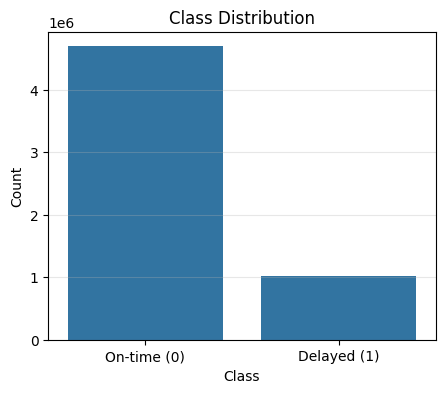

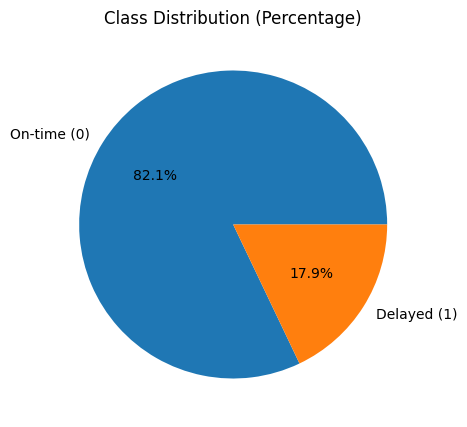

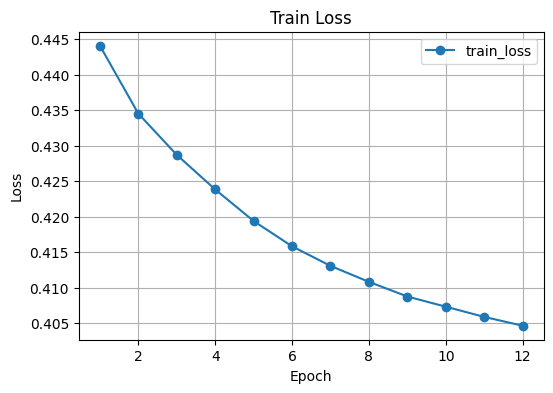

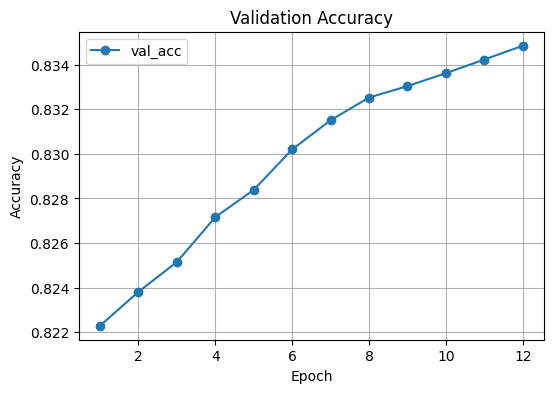

In [17]:
!pip install seaborn --quiet

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve

plt.style.use("default")

#Class distribution (Delayed vs On-time)
plt.figure(figsize=(5,4))
if "df_model" not in globals():
    df_model = df_flights[cat_cols + num_cols + ["DELAYED"]].dropna().copy()

sns.countplot(x=df_model["DELAYED"])
plt.xticks([0,1], ["On-time (0)", "Delayed (1)"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

#pie chart
class_counts = df_model["DELAYED"].value_counts()
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=["On-time (0)", "Delayed (1)"], autopct="%1.1f%%")
plt.title("Class Distribution (Percentage)")
plt.show()


#Training loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o", label="train_loss")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

#Validation accuracy curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(val_accs)+1), val_accs, marker="o", label="val_acc")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

model.eval()   # set model to eval mode

all_true = []
all_preds = []
all_probs = []

with torch.no_grad():
    for cat_x, num_x, y in test_loader:   # same order you used while training
        cat_x = cat_x.to(DEVICE)
        num_x = num_x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(cat_x, num_x)
        probs = torch.softmax(logits, dim=1)[:, 1]  # probability of class 1
        preds = torch.argmax(logits, dim=1)         # predicted class

        all_true.extend(y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_true = np.array(all_true)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("Shapes -> true:", all_true.shape, "| preds:", all_preds.shape, "| probs:", all_probs.shape)


Shapes -> true: (857102,) | preds: (857102,) | probs: (857102,)


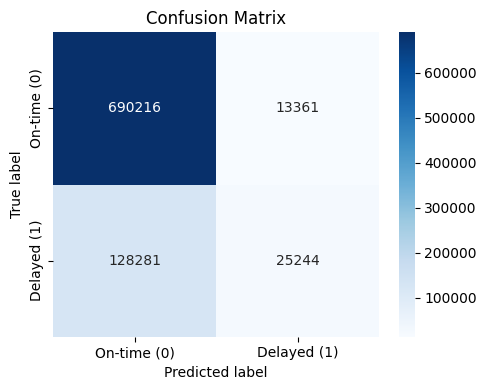


Classification report:

              precision    recall  f1-score   support

           0     0.8433    0.9810    0.9069    703577
           1     0.6539    0.1644    0.2628    153525

    accuracy                         0.8347    857102
   macro avg     0.7486    0.5727    0.5849    857102
weighted avg     0.8094    0.8347    0.7916    857102



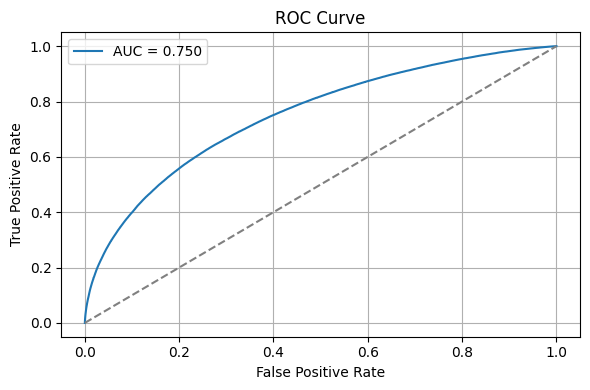

ROC–AUC: 0.7499098292860849


In [19]:
# plots

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# Confusion Matrix Heatmap
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["On-time (0)", "Delayed (1)"],
            yticklabels=["On-time (0)", "Delayed (1)"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

print("\nClassification report:\n")
print(classification_report(all_true, all_preds, digits=4))

# ROC Curve
fpr, tpr, _ = roc_curve(all_true, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("ROC–AUC:", roc_auc)
